# Nuclei detection using Mask-RCNN 


---
Authors: Lin Yang, Luomeng Tan, Magnus Lam

Department of Medical Biophysics, University of Toronto, Toronto, ON, Canada \
Princess Margaret Cancer Centre, Toronto, ON, Canada

In [ ]:
# dowload the dataset from google drive 
! gdown --id 1CX3x0YmRmDQivhjfgB0kVzfXzVql7Axj

# dowload the basic function 
! gdown --id 1H5qkBMhmxqGTip_OY1l2Pl3wsrP-LQ1v #data_process
! gdown --id 1yvJq5Nv5FfSqfW5jfrwcZKPI_MQv12-x #plot_functions
! gdown --id 1GPtHSWWd6BiVRi5YVJeJVX1-iIRkJGn_ #coco_eval

# unzip the dataset 
!unzip /content/stage1_train.zip

In [2]:
import os
import cv2
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader, random_split
from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
from albumentations.pytorch import ToTensorV2

from data_process import Load_data, Load_test_data, combined_mask, image_convert
from plot_functions import plot_img, plot_box, get_predicted_box, get_predicted_masks, plot_testing_img
from coco_eval import evaluate_IoU

In [3]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Load Data

In [4]:
#loading the datad
data_dir = '/content/stage1_train/'
data = Load_data(data_dir)

In [5]:
#data size
print(data.__len__())

670


/content/data_process.py:45: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  masks = torch.as_tensor(masks, dtype=torch.uint8)


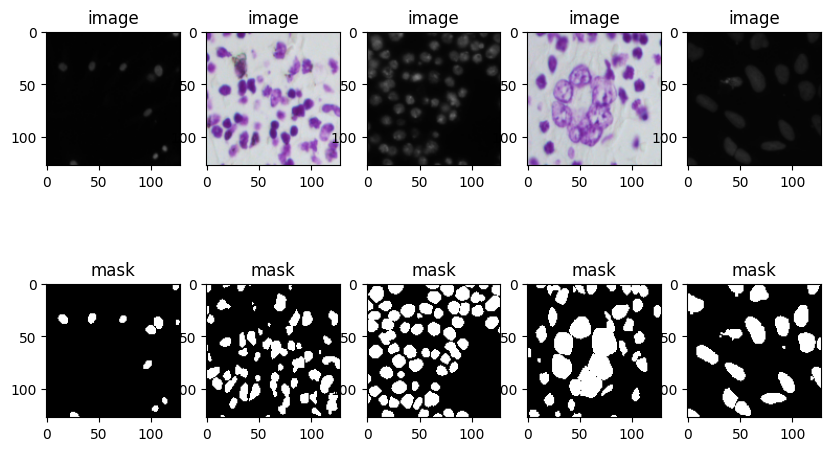

In [6]:
#Visualize five images and corresponding masks from the dataset 
plot_img(data, 5, device)

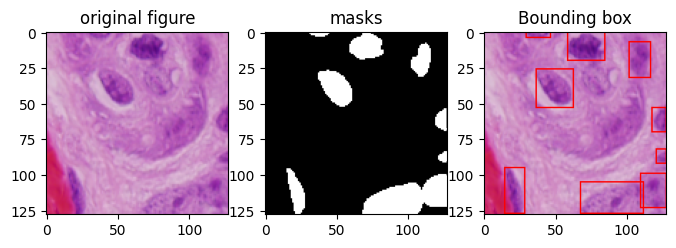

In [7]:
# visualization of input data
img, target = data.__getitem__(557)

plt.figure(figsize=(8,5))
plt.subplot(1,3,1)
plt.title('original figure')
plt.imshow(image_convert(img))

plt.subplot(1,3,2)
plt.title('masks')
plt.imshow(combined_mask(target['masks'], 128, 128), cmap='gray')


plt.subplot(1,3,3)
plt.title('Bounding box')
plt.imshow(plot_box(img, target['boxes']))

## Model Training

In [8]:
import torchvision.models.segmentation
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [9]:
## Access to the google drive
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [10]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [ ]:
model = get_model_instance_segmentation(2)
model.to(device)

In [ ]:
## set optimizer 
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=1e-5,
                            momentum=0.9, weight_decay=0.005)
model.train()

In [13]:
##### parameters setting #####
train_set = 580
batch_sizes = 2
iteration = 21
outdir = "/content/MyDrive/MyDrive/trained_model/"
##############################

loss_epoch = []
for i in range(iteration):       
    
    #how many batches used in each iteration 
    for b in range(batch_sizes):
        images = []
        targets = []
        idx=random.randint(0,train_set-1)
        image_, target_ = data.__getitem__(idx)
        images.append(image_)
        targets.append(target_)

    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
    print(f"start iteration {i}")
    optimizer.zero_grad()
    loss_dict = model(images, targets)

    losses = sum(loss for loss in loss_dict.values())
    losses.backward()
    optimizer.step()
    print(i,'loss:', losses.item())
    loss_epoch.append(losses.item())
    #save model for every 100 iteration 
    if i%500==0:
       torch.save(model.state_dict(), os.path.join(outdir,str(i)+"_wd01_batch" + str(batch_sizes)+ ".torch"))
df = pd.DataFrame (loss_epoch, columns = ['iteration'])
df.to_csv(os.path.join(outdir,str(i)+"_wd01_batch" + str(batch_sizes)+".loss.csv"), sep='\t')

start iteration 0
0 loss: 3.8158085346221924
start iteration 1
1 loss: 5.714535713195801
start iteration 2
2 loss: 6.104312419891357
start iteration 3
3 loss: 3.625675678253174
start iteration 4
4 loss: 2.7314414978027344
start iteration 5
5 loss: 7.815641403198242
start iteration 6
6 loss: 2.6981301307678223
start iteration 7
7 loss: 4.4767889976501465
start iteration 8
8 loss: 2.9455227851867676
start iteration 9
9 loss: 3.152773380279541
start iteration 10
10 loss: 2.6586954593658447
start iteration 11
11 loss: 4.008977890014648
start iteration 12
12 loss: 2.9541594982147217
start iteration 13
13 loss: 4.637833118438721
start iteration 14
14 loss: 2.9747371673583984
start iteration 15
15 loss: 2.447390556335449
start iteration 16
16 loss: 2.16970157623291
start iteration 17
17 loss: 3.040666341781616
start iteration 18
18 loss: 2.2491209506988525
start iteration 19
19 loss: 2.4472317695617676
start iteration 20
20 loss: 5.277682781219482


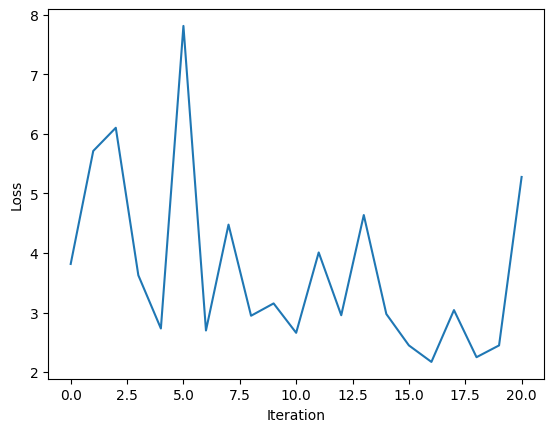

In [14]:
# Plot loss
plt.plot(list(range(len(loss_epoch))), loss_epoch)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

## Model Evaluation

In [ ]:
# load the trained model and switch to evaluation model 
model_path = "/content/MyDrive/MyDrive/trained_model/individual_mask/2000_individal_batch6.torch"

model = get_model_instance_segmentation(2)
model.load_state_dict(torch.load(model_path))
model.eval()
model.to(device)

In [16]:
## calculate the mAP and IoU on validation dataset 
evaluate_IoU(data, model, range(581, 670), device)

creating index...
index created!
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.665
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.921
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.785
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.665
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.073
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.682
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.727
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.727
 Average Recall     (AR) @[ IoU=0.50:0.95 | ar

In [17]:
### get one image from validation dataset 
imag, mak = data.__getitem__(644)
img = []
img.append(imag)
img = list(image.to(device) for image in img)

In [18]:
# testing the model 
with torch.no_grad():
    pred = model(img)

In [19]:
## get predicted boxes with score > 0.5
pred_box = get_predicted_box(pred, cutoff = 0.5)
p_0 = plot_box(imag, pred_box)

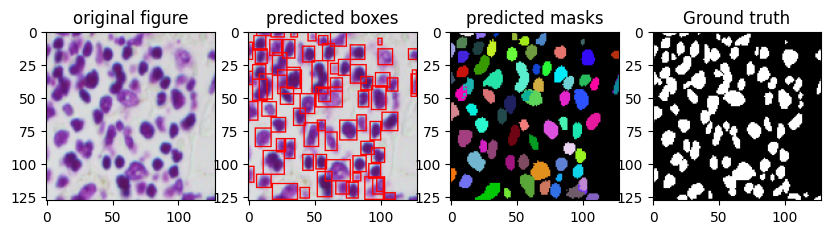

In [20]:
plt.figure(figsize=(10,6))
plt.subplot(1,4,1)
plt.title('original figure')
plt.imshow(image_convert(imag))

plt.subplot(1,4,2)
plt.title('predicted boxes')
plt.imshow(p_0)

plt.subplot(1,4,3)
plt.title('predicted masks')
plt.imshow(get_predicted_masks(imag, pred, cutoff = 0.5))

plt.subplot(1,4,4)
plt.title('Ground truth')
plt.imshow(combined_mask(mak['masks'], 128,128), cmap='gray')

## Test the model using testing data

In [ ]:
# dowload the test dataset from google drive 
! gdown --id 1QGmq8gloxGD3308vqilc0hzyukxjT52E
# unzip the dataset 
!unzip /content/stage1_test.zip

In [22]:
test_data = Load_test_data("/content/stage1_test")

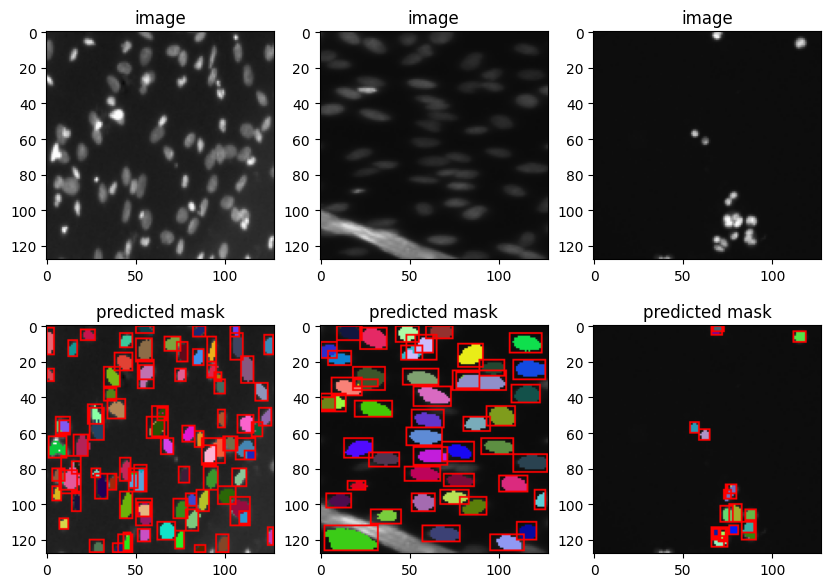

In [23]:
# plot the figure 14, 54, 2 from testing data
image_id = [14, 54, 2]
plot_testing_img(test_data, image_id, model, device)